In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import time
import datashader as ds

import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
from __init__scr import *
import utils
import powerplot

- v1 - not used
- v2 - current (works)
- v3 - add rna
- v4 - remove enhancers with <100bp

In [2]:
# old to new batch
f = '/cndd2/fangming/projects/scf_enhancers/ABC-Enhancer-Gene-Prediction/v3/mop_abc_enhs_allcelltypes_match_enhs_list.bed'
match = pd.read_csv(f, sep='\t', header=None)
match = match[[3,7,8]]
match.columns = ['abc', 'mine', 'd']
match = match.groupby('abc').first()

match

,mine,d
abc,,
chr10:100009482-100009982,chr10:100009732-100010967,617
chr10:100018280-100018780,chr10:100018530-100019593,531
chr10:100019354-100019854,chr10:100019604-100019864,130
chr10:100019945-100020445,chr10:100020195-100020328,66
chr10:100022162-100022662,chr10:100022412-100022744,166
...,...,...
chrX:99843574-99844074,chrX:99843824-99844135,155
chrX:99852936-99853436,chrX:99853186-99853303,58
chrX:9996944-9997444,chrX:9997194-9997721,263


In [3]:
# read
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/ABC-Enhancer-Gene-Prediction/v3/mop_prefiltered_results_allcelltypes.txt.gz'
abc = pd.read_csv(f, sep='\t')
print(time.time()-ti)
print(abc.shape)

# match with old regions
_ = abc['chr']+":"+abc['start'].astype(str)+"-"+abc['end'].astype(str).values
abc['enh_name'] = match.loc[_, 'mine'].values
print(time.time()-ti)

# categorize
default_th = 0.022
cond_sigabc = (abc['powerlaw.Score'] > default_th)
scorecat, bins = pd.qcut(abc['powerlaw.Score'][cond_sigabc], 3, retbins=True, labels=['1-low', '2-mid', '3-high'])
abc = abc.join(scorecat.to_frame('abc_cat'))
print(time.time()-ti)

print(cond_sigabc.sum())
print(bins)

print(abc.columns)
print(abc.shape)
abc

19.684378385543823
(8132300, 21)
33.02871775627136
34.27795171737671
1921617
[0.022001   0.03691167 0.073739   1.        ]
Index(['chr', 'start', 'end', 'name', 'class', 'activity_base', 'enh_midpoint',
       'enh_idx', 'TargetGene', 'TargetGeneTSS', 'TargetGeneExpression',
       'TargetGenePromoterActivityQuantile', 'TargetGeneIsExpressed',
       'gene_idx', 'distance', 'isSelfPromoter', 'powerlaw_contact',
       'powerlaw_contact_reference', 'powerlaw.Score.Numerator',
       'powerlaw.Score', 'CellType', 'enh_name', 'abc_cat'],
      dtype='object')
(8132300, 23)


,chr,start,end,name,class,activity_base,enh_midpoint,enh_idx,TargetGene,TargetGeneTSS,...,gene_idx,distance,isSelfPromoter,powerlaw_contact,powerlaw_contact_reference,powerlaw.Score.Numerator,powerlaw.Score,CellType,enh_name,abc_cat
0,chr16,3852262,3852762,genic|chr16:3852262-3852762,genic,0.397924,3852512.0,111591,ENSMUSG00000059043,3830878,...,26489,21634.0,False,0.034517,0.034517,0.013735,0.040245,1-1-1,chr16:3852512-3853072,2-mid
1,chr16,3852262,3852762,genic|chr16:3852262-3852762,genic,0.397924,3852512.0,111591,ENSMUSG00000054939,3847268,...,26490,5244.0,False,0.118425,0.118425,0.047124,0.121454,1-1-1,chr16:3852512-3853072,3-high
2,chr16,3852262,3852762,genic|chr16:3852262-3852762,genic,0.397924,3852512.0,111591,ENSMUSG00000097590,3862384,...,26492,9872.0,False,0.068305,0.068305,0.027180,0.069964,1-1-1,chr16:3852512-3853072,2-mid
3,chr16,3852262,3852762,genic|chr16:3852262-3852762,genic,0.397924,3852512.0,111591,ENSMUSG00000005982,3872375,...,26493,19863.0,False,0.037179,0.037179,0.014795,0.036367,1-1-1,chr16:3852512-3853072,1-low
4,chr16,3852262,3852762,genic|chr16:3852262-3852762,genic,0.397924,3852512.0,111591,ENSMUSG00000039789,3884561,...,26491,32049.0,False,0.024522,0.024522,0.009758,0.020059,1-1-1,chr16:3852512-3853072,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132295,chr14,124674258,124674758,genic|chr14:124674258-124674758,genic,0.000000,124674508.0,98966,ENSMUSG00000115490,124742797,...,19028,68289.0,False,0.012698,0.012698,0.000000,0.000000,2-3-2,chr14:124674508-124674579,NaN
8132296,chr14,124714053,124714553,intergenic|chr14:124714053-124714553,intergenic,0.000000,124714303.0,98967,ENSMUSG00000025551,124677127,...,19025,37176.0,False,0.021552,0.021552,0.000000,0.000000,2-3-2,chr14:124714303-124714690,NaN
8132297,chr14,124714053,124714553,intergenic|chr14:124714053-124714553,intergenic,0.000000,124714303.0,98967,ENSMUSG00000115490,124742797,...,19028,28494.0,False,0.027163,0.027163,0.000000,0.000000,2-3-2,chr14:124714303-124714690,NaN
8132298,chr14,124724222,124724722,intergenic|chr14:124724222-124724722,intergenic,0.000000,124724472.0,98968,ENSMUSG00000025551,124677127,...,19025,47345.0,False,0.017463,0.017463,0.000000,0.000000,2-3-2,chr14:124724472-124724769,NaN


198

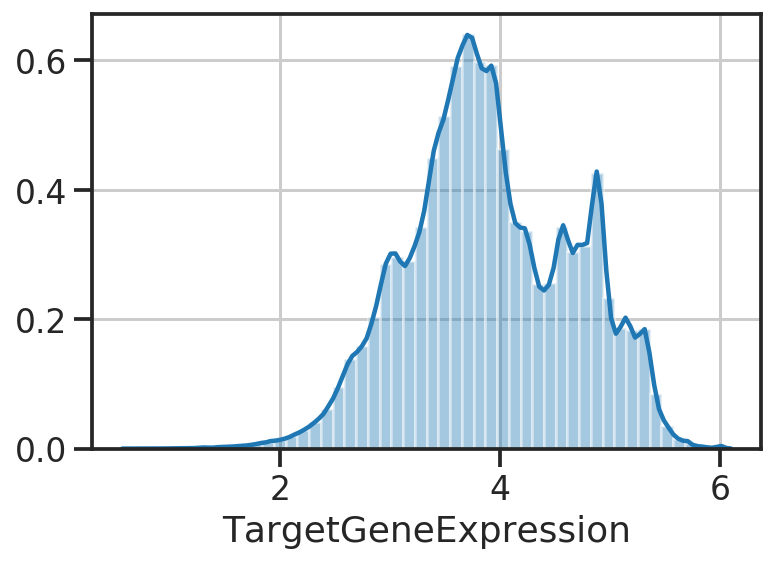

In [87]:
sns.distplot(np.log10(abc['TargetGeneExpression']))
(np.log10(abc['TargetGeneExpression'])<1).sum()

In [88]:
abc = abc[abc['TargetGeneExpression']>10] #.shape

# Compare with my predictions 

In [89]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [90]:
import datetime
today = datetime.date.today().strftime("%y%m%d")
CORRCOEF_TYPE = 'Spearmanr' # Pearsonr
print(today)

210723


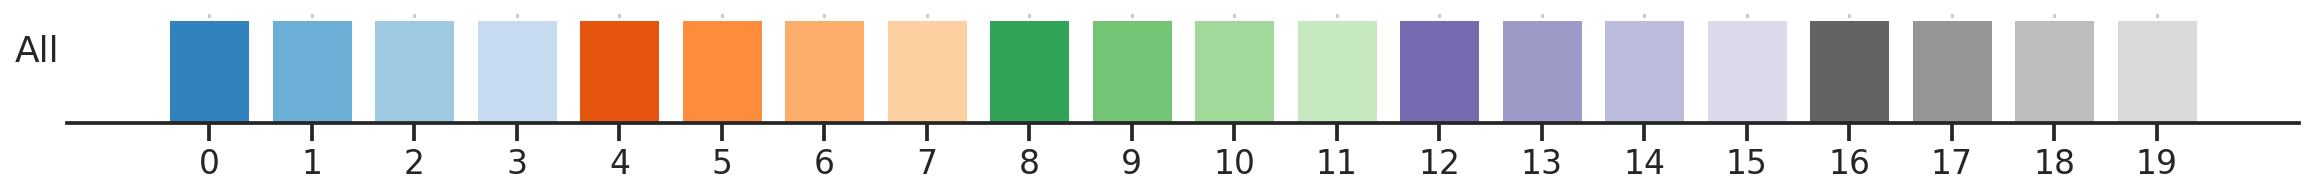

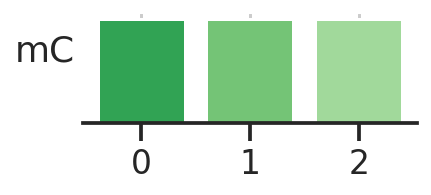

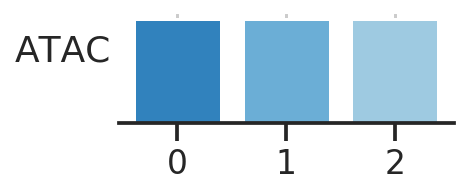

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


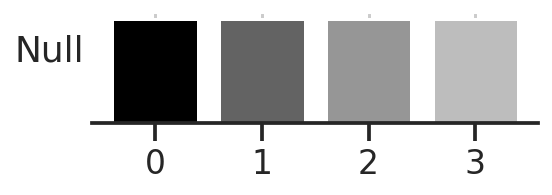

In [91]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [92]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000

def p25(x):
    return np.nanpercentile(x, 25)

def p75(x):
    return np.nanpercentile(x, 75)

def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

In [93]:
# genes
# enhs
# to_evals
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_appended_201212.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})
print(to_evals.shape)

(31053, 11)
(233514, 7)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2589994, 4)


<ipython-input-93-22243a218237>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})


In [94]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']
def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [95]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
enh_list_expand['name'] = enh_list_expand['chr']+':'+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 17)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist,name
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,chr1:3083769-3083816
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,chr1:3112234-3112467
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,chr1:3112770-3112986
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,chr1:3113717-3114035
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,chr1:3118790-3118935


# Analysis 

In [96]:
# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201206_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)
print(res_clsts.shape)

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  3.18it/s]

(41, 4)


In [97]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
iterator_both = pd.merge(iterator_both, res_clsts)
print(iterator_both.shape)
iterator_both.sort_values('r')

(30, 4)
(21, 4)
(21, 6)


,r,i,k,fname_mc,fname_atac,num_clst
0,1.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,16
1,1.258925,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,18
2,1.584893,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,22
3,1.995262,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,28
9,2.511886,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,34
11,3.162278,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,39
12,3.981072,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,52
15,5.011872,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,62
17,6.309573,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,75
19,7.943282,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,90


# one analysis 

In [98]:
# choose 1 (r=100; num_clst=935) to proceed 
num_clst = 256
fname1, fname2, resolution = iterator_both[iterator_both['num_clst']==num_clst][['fname_mc', 'fname_atac', 'r']].iloc[0]
print(fname1)
print(fname2)

output_figures = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
output_results = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
print(output_figures)
print(output_results)

/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snatac_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210723_r25.1_n256_{}
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_210723_r25.1_n256_{}


In [99]:
## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


In [100]:
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = to_evals[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


### Statistical evaluation 

In [101]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [102]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

def venn_ax(ax, title, sets, set_labels, set_colors, 
            intformat=True,
             **kwargs):
    """
    venn2 or venn3
    kwargs include: normalize_to
    """
    if len(sets) == 3:
        out = venn3(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    elif len(sets) == 2:
        out = venn2(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    ax.set_title(title)
    
    if intformat:
        for text in out.subset_labels:
            text.set_text("{:,}".format(int(text.get_text())))
            text.set_fontsize(10)
    return out

In [103]:
# add enh_name column to tables # old results
enh_list_expand['enh_name'] = enh_list_expand['chr']+":"+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
res2_stats['linked_table']['enh_name'] = enh_list_expand.set_index('index').loc[res2_stats['linked_table']['enh']]['enh_name'].values
res2_corrs['enh_name'] = enh_list_expand.set_index('index').loc[res2_corrs['enh']]['enh_name'].values

res_stats['linked_table']['enh_name'] = enh_list_expand.set_index('index').loc[res_stats['linked_table']['enh']]['enh_name'].values
res_corrs['enh_name'] = enh_list_expand.set_index('index').loc[res_corrs['enh']]['enh_name'].values

In [104]:
# genes
g_old = res2_stats['linked_table']['gene'].unique()
g_new = abc['TargetGene'].unique()
common_genes = np.intersect1d(g_old, g_new)
print(g_old.shape, g_new.shape, common_genes.shape)

# enhancers
e_old = res2_stats['linked_table']['enh_name'].unique()
e_new = abc['enh_name'].unique()
common_enhs = np.intersect1d(e_old, e_new)
print(e_old.shape, e_new.shape, common_enhs.shape)

(2459,) (25537,) (2459,)
(7938,) (159325,) (7305,)


In [105]:
abc_max = abc[['TargetGene', 'enh_name', 'powerlaw.Score']].groupby(['TargetGene', 'enh_name']).max().reset_index()
merged_max = pd.merge(
    res2_corrs, 
    abc_max.rename(columns={'TargetGene': 'gene'}),
    on=['gene', 'enh_name'],
    )
merged_max_mc = pd.merge(
    res_corrs, 
    abc_max.rename(columns={'TargetGene': 'gene'}),
    on=['gene', 'enh_name'],
    )

print(abc_max.shape, merged_max.shape)
print(abc_max.shape, merged_max_mc.shape)

(455179, 3) (204871, 9)
(455179, 3) (204871, 9)


In [106]:
# abc_mean = abc[['TargetGene', 'enh_name', 'powerlaw.Score']].groupby(['TargetGene', 'enh_name']).mean().reset_index()
# abc_median = abc[['TargetGene', 'enh_name', 'powerlaw.Score']].groupby(['TargetGene', 'enh_name']).median().reset_index()

# merged_mean = pd.merge(
#     res2_corrs, 
#     abc_mean.rename(columns={'TargetGene': 'gene'}),
#     on=['gene', 'enh_name'],
#     )
# merged_median = pd.merge(
#     res2_corrs, 
#     abc_median.rename(columns={'TargetGene': 'gene'}),
#     on=['gene', 'enh_name'],
#     )

# fig, ax = plt.subplots()
# sns.scatterplot(x='corr', y='powerlaw.Score', data=merged_max, s=10, 
#                 facecolor='',
#                 ax=ax)
# plt.show()

# # abc_th = 0.022
# # merged_max['abc_pos'] = merged_max['powerlaw.Score'] > abc_th
# # merged_max['1'] = 1
# # abcpos_counts = merged_max[['corr', 'abc_pos', '1']].groupby([pd.qcut(merged_max['corr'], 10)]).sum()
# # abcpos_counts

# # leftpoints = [i.left for i in abcpos_counts.index.values.categories]

# # fig, ax = plt.subplots()
# # ax.plot(leftpoints, abcpos_counts['abc_pos'].values/abcpos_counts['1'].values)
# # plt.show()

# abcpos_mean = merged_max[['corr', 'powerlaw.Score']].groupby([pd.qcut(merged_max['corr'], 20)]).mean()

# leftpoints = [i.left for i in abcpos_mean.index.values.categories]
# rightpoints = [i.right for i in abcpos_mean.index.values.categories]
# heights = abcpos_mean['powerlaw.Score'].values

# _x = np.vstack([leftpoints, rightpoints]).T.flatten()
# _y = np.repeat(heights, 2)

# fig, ax = plt.subplots()
# ax.plot(_x, _y)
# plt.show()

In [107]:
def get_mean_trend(data, x, y, qbins=0, bins=0, mean=True):
    """
    """
    if qbins:
        grpby = pd.qcut(data[x], qbins)
    elif bins:
        grpby = pd.cut(data[x], bins)
        
    if mean:
        data_mean = data[[x, y]].groupby([grpby]).mean()
    else:
        data_mean = data[[x, y]].groupby([grpby]).median()
        

    leftpoints = [i.left for i in data_mean.index.values.categories]
    rightpoints = [i.right for i in data_mean.index.values.categories]
    heights = data_mean[y].values

    _x = np.vstack([leftpoints, rightpoints]).T.flatten()
    _y = np.repeat(heights, 2)
    
    return _x, _y

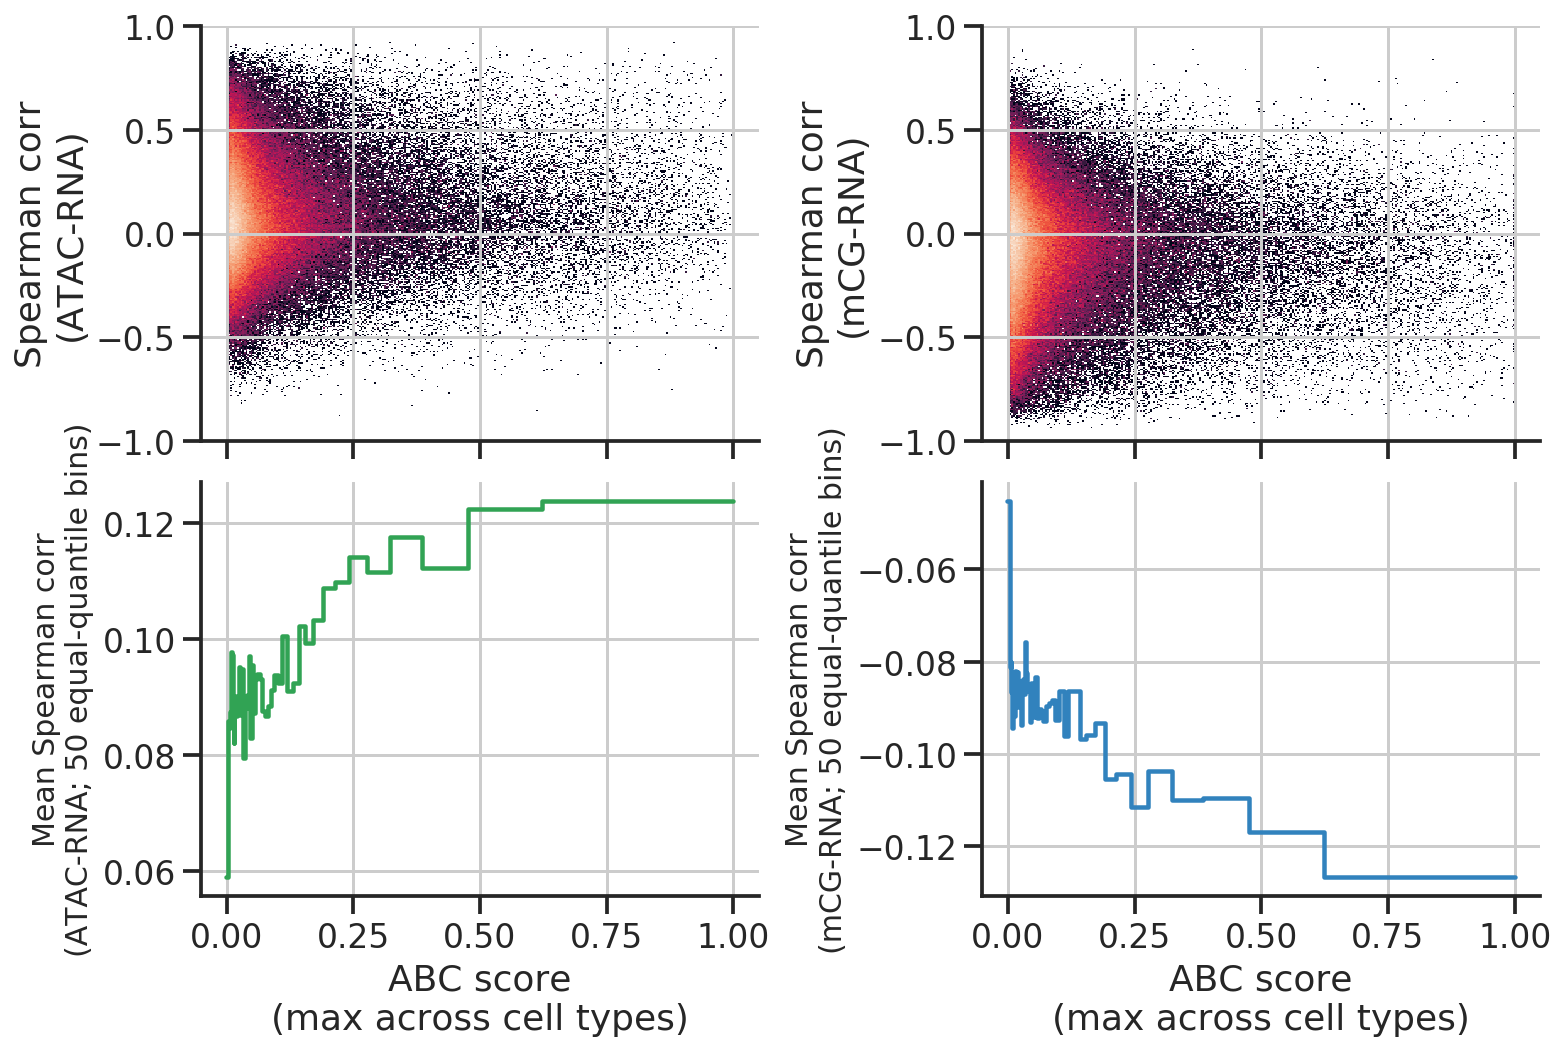

In [108]:
# data, x, y = merged_max, 'corr', 'powerlaw.Score'

fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2), sharex=True)
axs = axs.flat

ax = axs[0]
data, x, y = merged_max,  'powerlaw.Score', 'corr',
qbins = 50
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_ylim([-1,1])
sns.despine(ax=ax)
ax.set_ylabel('Spearman corr\n(ATAC-RNA)')
ax.set_xlabel('')

ax = axs[1]
data, x, y = merged_max_mc,  'powerlaw.Score', 'corr',
qbins = 50
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_ylim([-1,1])
sns.despine(ax=ax)
ax.set_ylabel('Spearman corr\n(mCG-RNA)')
ax.set_xlabel('')

ax = axs[2]
data, x, y = merged_max,  'powerlaw.Score', 'corr',
qbins = 50
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_mc[0])
sns.despine(ax=ax)
ax.set_ylabel('Mean Spearman corr\n(ATAC-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)
ax.set_xlabel('ABC score\n(max across cell types)')

ax = axs[3]
data, x, y = merged_max_mc,  'powerlaw.Score', 'corr',
qbins = 50
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_atac[0])
sns.despine(ax=ax)
ax.set_ylabel('Mean Spearman corr\n(mCG-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)
ax.set_xlabel('ABC score\n(max across cell types)')

fig.subplots_adjust(wspace=0.4, hspace=0.1)
plt.show()

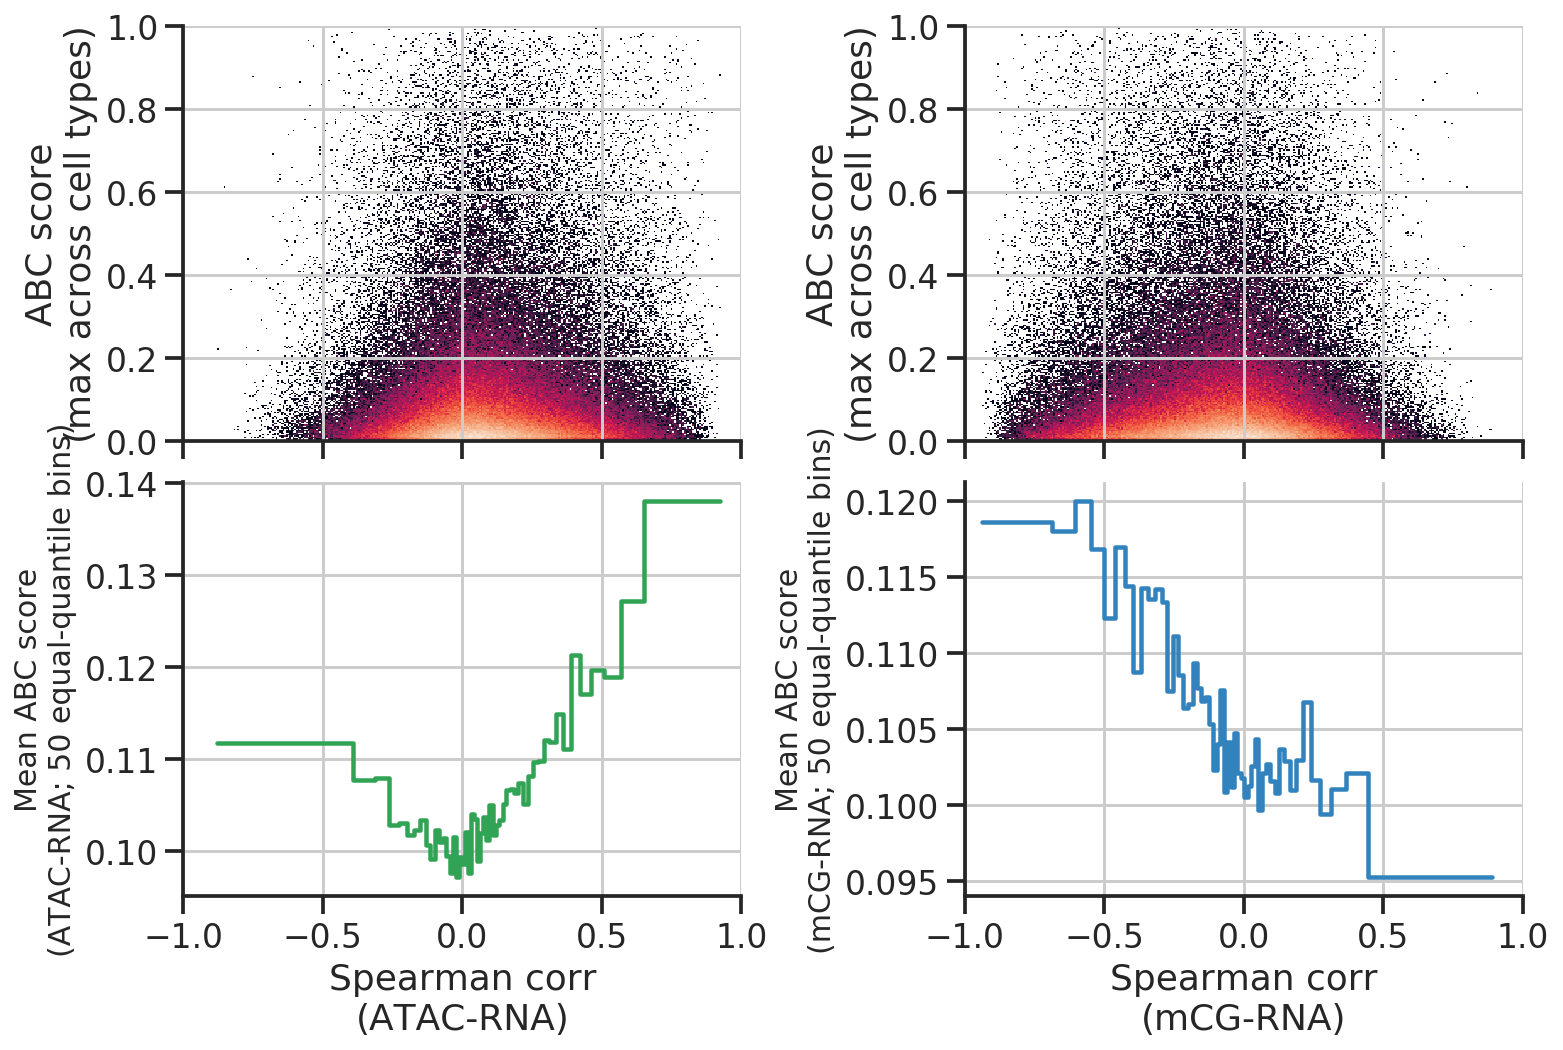

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2), sharex=True)
axs = axs.flat

ax = axs[0]
data, x, y = merged_max, 'corr', 'powerlaw.Score', 
qbins = 50
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('ABC score\n(max across cell types)')

ax = axs[1]
data, x, y = merged_max_mc, 'corr', 'powerlaw.Score', 
qbins = 50
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('ABC score\n(max across cell types)')

ax = axs[2]
data, x, y = merged_max, 'corr', 'powerlaw.Score', 
qbins = 50
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_mc[0])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(ATAC-RNA)')
ax.set_ylabel('Mean ABC score\n(ATAC-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)

ax = axs[3]
data, x, y = merged_max_mc, 'corr', 'powerlaw.Score',
qbins = 50
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_atac[0])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(mCG-RNA)')
ax.set_ylabel('Mean ABC score\n(mCG-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)

fig.subplots_adjust(wspace=0.4, hspace=0.1)
plt.show()

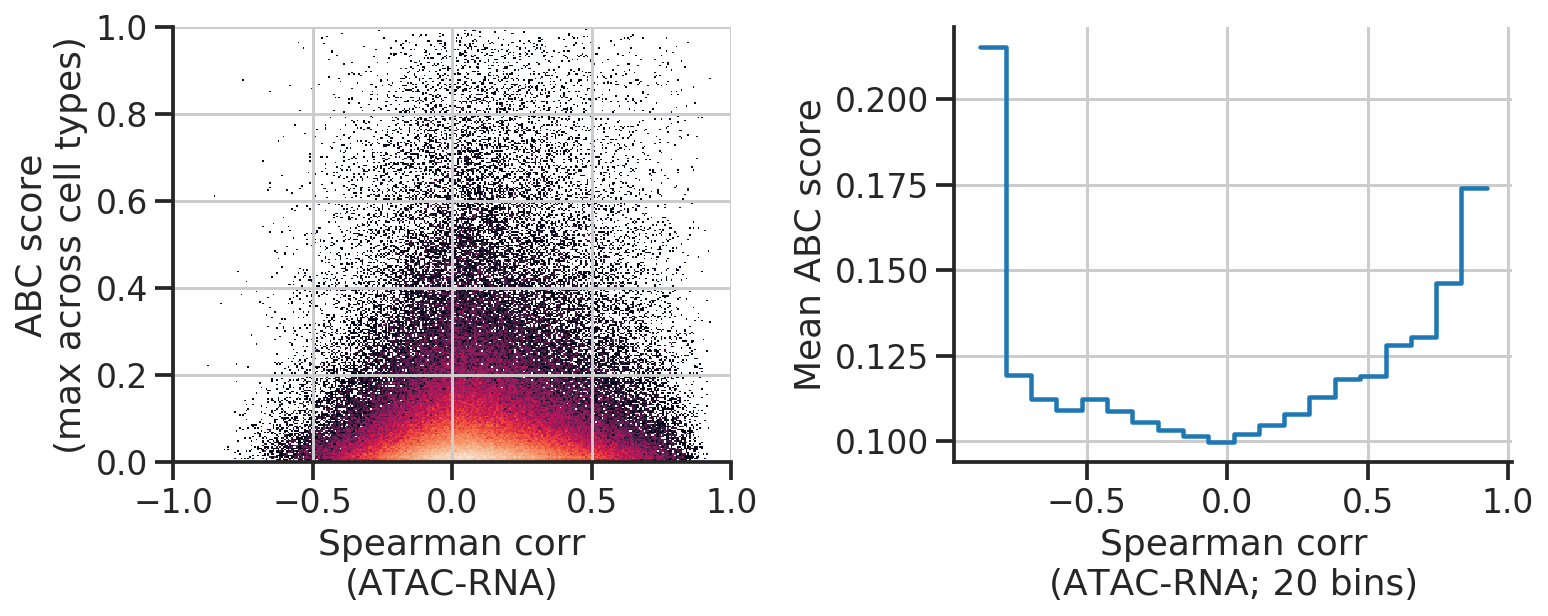

In [30]:
data, x, y = merged_max, 'corr', 'powerlaw.Score'
bins = 20

fig, axs = plt.subplots(1, 2, figsize=(6*2,4))
ax = axs[0]
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(ATAC-RNA)')
ax.set_ylabel('ABC score\n(max across cell types)')

ax = axs[1]
_x, _y = get_mean_trend(data, x, y, bins=bins)
ax.plot(_x, _y)
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(ATAC-RNA; {} bins)'.format(bins))
ax.set_ylabel('Mean ABC score')

fig.subplots_adjust(wspace=0.4)
plt.show()

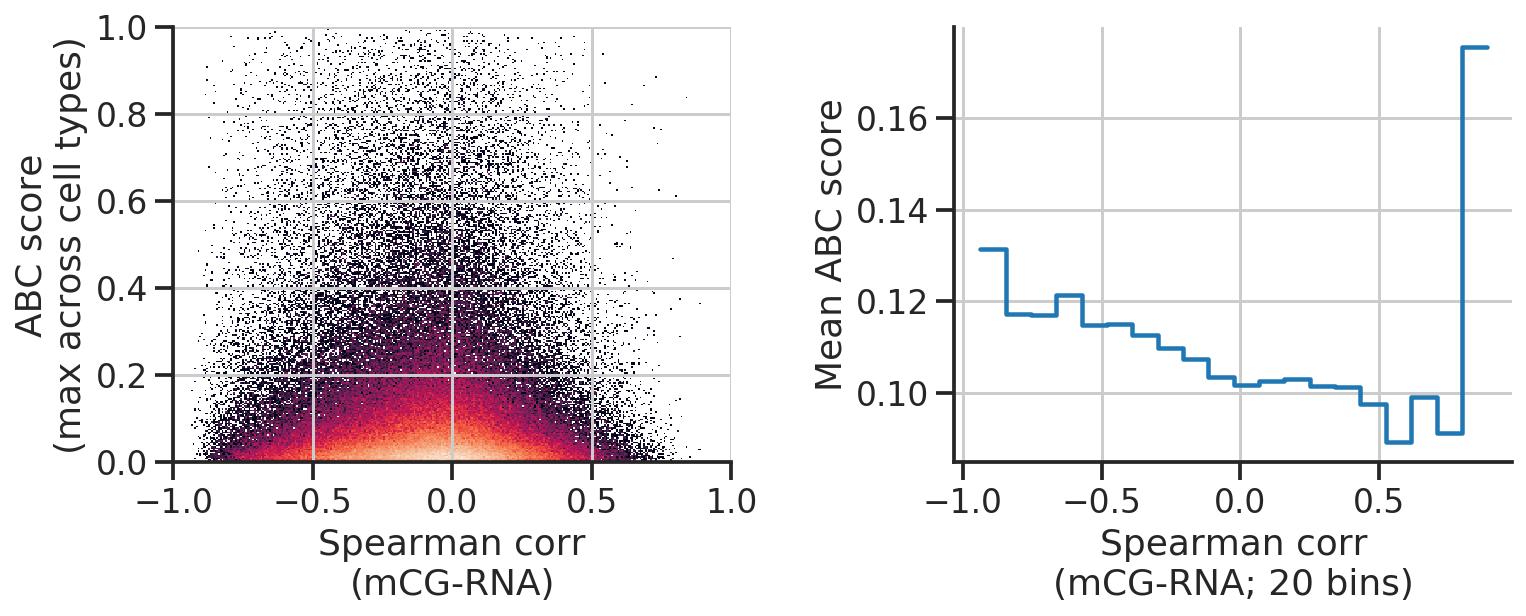

In [32]:
data, x, y = merged_max_mc, 'corr', 'powerlaw.Score'
bins = 20

fig, axs = plt.subplots(1, 2, figsize=(6*2,4))
ax = axs[0]
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(mCG-RNA)')
ax.set_ylabel('ABC score\n(max across cell types)')

ax = axs[1]
_x, _y = get_mean_trend(data, x, y, bins=bins)
ax.plot(_x, _y)
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(mCG-RNA; {} bins)'.format(bins))
ax.set_ylabel('Mean ABC score')

fig.subplots_adjust(wspace=0.4)
plt.show()

TypeError: 'int' object is not subscriptable

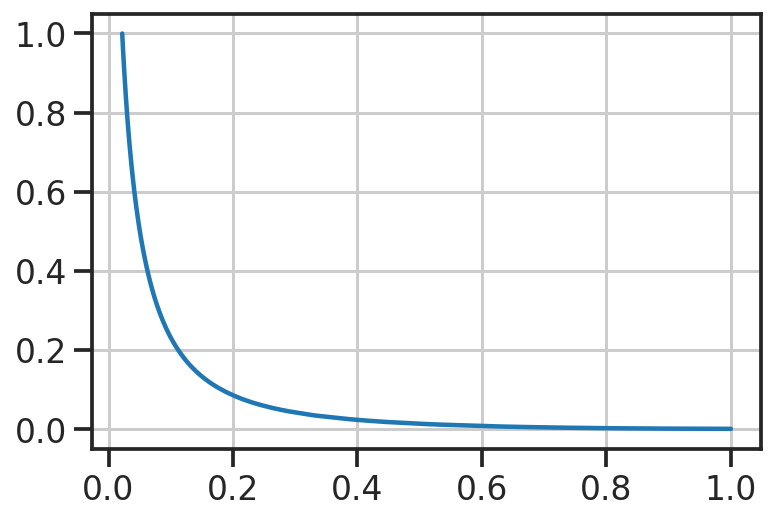

In [33]:
fig, ax = plt.subplots()
x, y = powerplot.gen_cdf(abc['powerlaw.Score'][cond_sigabc], ax=ax, flip=True,)

ax.vlines(bins[1:-1], 0, 1, linestyle='--', color='grey')
for _x in bins[1:-1]:
    ax.text(_x, 0, "{:.2g}".format(_x), fontsize=12)

sns.despine(ax=ax)
ax.set_xlabel('ABC score')
ax.set_ylabel('Fraction of pairs with score > x')
ax.set_yticks([0, 1/3, 2/3, 1])
ax.set_xscale('log')
ax.set_xlim([0.01, 1])
plt.show()

### TODO: remove promoters? 

In [ ]:
abc.groupby('abc_cat').size()

In [ ]:
highset = abc[((abc['abc_cat']=='3-high') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
highset = set(highset['TargetGene'].str.cat(highset['enh_name'], sep=',').tolist()) 
print(len(highset))

midset = abc[((abc['abc_cat']=='2-mid') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
midset = set(midset['TargetGene'].str.cat(midset['enh_name'], sep=',').tolist()) 
print(len(midset))

lowset = abc[((abc['abc_cat']=='1-low') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
lowset = set(lowset['TargetGene'].str.cat(lowset['enh_name'], sep=',').tolist()) 
print(len(lowset))

resset = set(res2_stats['linked_table']['gene'].str.cat(res2_stats['linked_table']['enh_name'], sep=',').tolist())
print(len(resset))

In [ ]:
output = output_figures.format('ven_pairs_correlated.pdf')

title = ''

ref_area = len(highset|resset)

fig, axs = plt.subplots(1,3,figsize=(3*6,1*6))
ax = axs[0]
venn_ax(ax, title, 
        [highset, resset], 
        ['ABC high', 'linked pairs (ATAC)'], 
        ['C0', 'C1'], 
       )
true_area = len(highset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

ax = axs[1]
venn_ax(ax, title, 
        [midset, resset], 
        ['ABC mid', 'linked pairs (ATAC)'], 
        ['C0', 'C1'],
       )
true_area = len(midset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

ax = axs[2]
venn_ax(ax, title, 
        [lowset, resset], 
        ['ABC low', 'linked pairs (ATAC)'], 
        ['C0', 'C1'],
       )
true_area = len(lowset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)
